In [12]:
import tensorflow as tf
import json
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
oov_token = "<OOV>"

In [4]:
with open("sarcasm.json", "r") as f:
    dataset = json.load(f)

In [6]:
sentences = []
labels = []

for items in dataset:
    sentences.append(items['headline'])
    labels.append(items['is_sarcastic'])

In [7]:
training_sentences = sentences[0:20000]
testing_sentences = sentences[20000:]

training_labels = labels[0:20000]
testing_labels = labels[20000:]

In [11]:
tokenizer = Tokenizer(oov_token = oov_token)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences)

In [17]:
vocab_size = len(word_index)
embedding_dim = 16
testing_padded.shape

(6709, 38)

In [13]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = 38),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 38, 16)            410208    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 410,641
Trainable params: 410,641
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(training_padded, training_labels, epochs = 30,
                   validation_data=(testing_padded, testing_labels))

Epoch 1/30
625/625 [==============================] - 2s 3ms/step - loss: 0.5881 - accuracy: 0.6805 - val_loss: 0.4088 - val_accuracy: 0.8289
Epoch 2/30
625/625 [==============================] - 1s 2ms/step - loss: 0.3114 - accuracy: 0.8778 - val_loss: 0.3421 - val_accuracy: 0.8554
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2124 - accuracy: 0.9204 - val_loss: 0.3376 - val_accuracy: 0.8599
Epoch 4/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1499 - accuracy: 0.9477 - val_loss: 0.3634 - val_accuracy: 0.8536
Epoch 5/30
625/625 [==============================] - 2s 2ms/step - loss: 0.1059 - accuracy: 0.9666 - val_loss: 0.3877 - val_accuracy: 0.8560
Epoch 6/30
625/625 [==============================] - 1s 2ms/step - loss: 0.0754 - accuracy: 0.9780 - val_loss: 0.4288 - val_accuracy: 0.8506
Epoch 7/30
625/625 [==============================] - 2s 2ms/step - loss: 0.0534 - accuracy: 0.9852 - val_loss: 0.4761 - val_accuracy: 0.8436
Epoch 

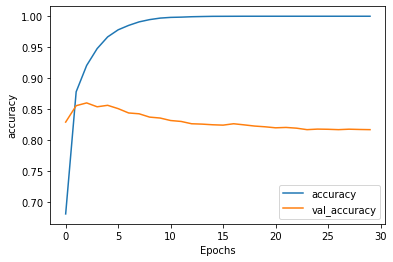

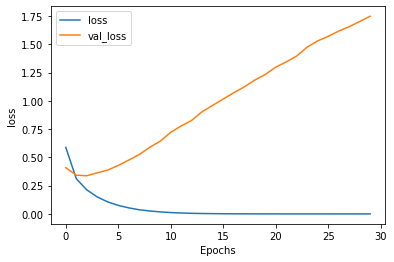

In [28]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [29]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? former versace store clerk sues over secret 'black code' for minority shoppers
mom starting to fear son's web series closest thing she will have to grandchild
1


In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(25638, 16)


In [31]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [33]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences)
print(model.predict(padded))

[[1.0000000e+00]
 [8.0281393e-07]]
